In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

print(f'Using device {device}')

Using device cuda


In [3]:
from models import *
from models.unet import *

IMAGE = 'zebra'
factor = 4

input_depth = 32

nd = [128, 128, 128, 128, 128]
nu = nd[:]
kd = [3, 3, 3, 3, 3]
ku = kd[:]
ns = [4, 4, 4, 4, 4]
ks = [1, 1, 1, 1, 1]

if IMAGE == 'zebra':
    net = UNet(input_depth, 3, nu, nd, ns, ku, kd, ks, weight_std=1./30)
    fname = './data/sr/zebra_GT.png'
else:
    assert False

net.to(device)
print(f'Image is {IMAGE}')
print(net)

Image is zebra
UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv

In [4]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 2873575


Image dim : (3, 384, 576)


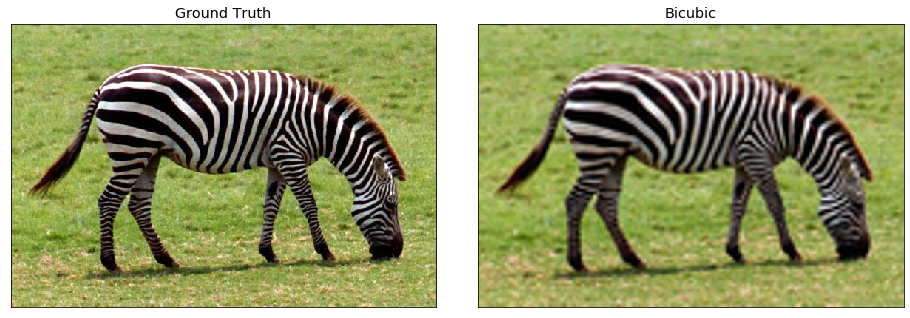

In [5]:
from utils import *
from input_gen import *

img_hr_pil = crop_image(get_image(fname, -1)[0])
img_hr_np = pil_to_np(img_hr_pil)
img_hr_tr = torch.from_numpy(img_hr_np).type(torch.FloatTensor)

hr_width, hr_height = img_hr_pil.size
lr_size = (hr_width // factor, hr_height // factor)
img_lr_pil = img_hr_pil.resize(lr_size, Image.LANCZOS)
img_lr_np = pil_to_np(img_lr_pil)
img_lr_tr = torch.from_numpy(img_lr_np).type(torch.FloatTensor)

img_bicubic_pil = img_lr_pil.resize(img_hr_pil.size, Image.BICUBIC)
img_bicubic_np = pil_to_np(img_bicubic_pil)
img_bicubic_tr = torch.from_numpy(img_bicubic_np).type(torch.FloatTensor)

print(f'Image dim : {img_hr_np.shape}')

fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr],
                              titles=['Ground Truth', 'Bicubic'],
                              figsize=(16,16))

In [6]:
target_img = img_hr_tr
target_img = target_img.unsqueeze(dim=0).to(device)
net_input = get_noise(input_depth, *img_hr_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()

# HyperParmaters for each image
if factor == 4:
    LR = 0.01
    num_iter = 2000
    reg_noise_std = 1.0/30
elif factor == 8:
    LR = 0.01
    num_iter = 4000
    reg_noise_std = 1.0/20
    
if reg_noise_std > 0:
        net_input = net_input + (noise.normal_() * reg_noise_std)
        
print(f'Hyperparameters : LR = {LR},  num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : LR = 0.01,  num_iter = 2000,  std = 0.03333333333333333


C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([3, 96, 144])) that is different to the input size (torch.Size([1, 3, 96, 144])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


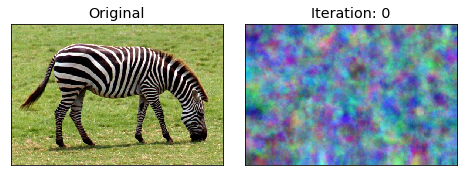

Iteration  50   Loss = 0.013046   PSNR_LR = 18.845212   PSNR_HR=16.61831818 
Iteration  100   Loss = 0.001921   PSNR_LR = 27.164296   PSNR_HR=16.90495858 


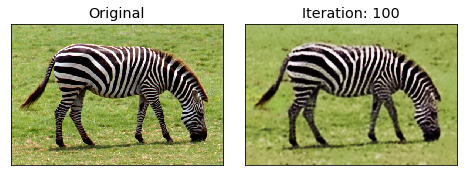

Iteration  150   Loss = 0.001153   PSNR_LR = 29.381943   PSNR_HR=16.76273636 
Iteration  200   Loss = 0.000726   PSNR_LR = 31.389012   PSNR_HR=16.68575252 


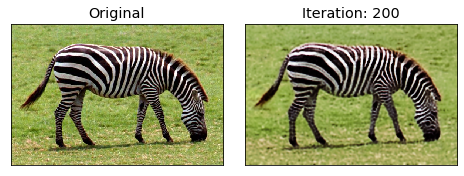

Iteration  250   Loss = 0.000426   PSNR_LR = 33.705174   PSNR_HR=16.66700000 
Iteration  300   Loss = 0.000332   PSNR_LR = 34.782772   PSNR_HR=16.61933838 


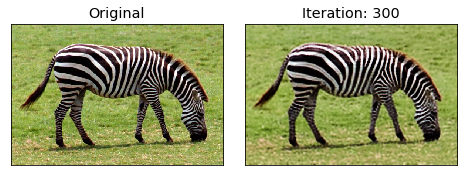

Iteration  350   Loss = 0.000283   PSNR_LR = 35.478863   PSNR_HR=16.59908080 
Iteration  400   Loss = 0.000359   PSNR_LR = 34.452126   PSNR_HR=16.56945656 


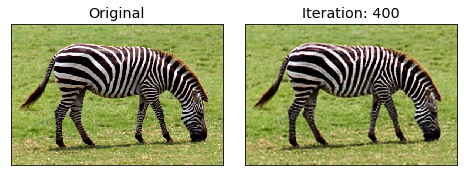

Iteration  450   Loss = 0.000200   PSNR_LR = 37.000365   PSNR_HR=16.55564343 
Iteration  500   Loss = 0.000177   PSNR_LR = 37.515281   PSNR_HR=16.54094646 


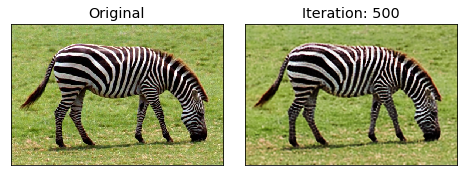

Iteration  550   Loss = 0.000173   PSNR_LR = 37.611272   PSNR_HR=16.54324444 
Iteration  600   Loss = 0.000138   PSNR_LR = 38.593806   PSNR_HR=16.51171515 


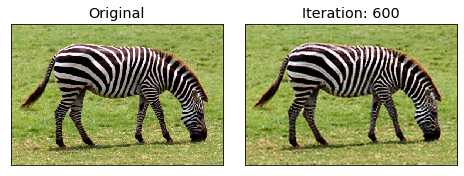

Iteration  650   Loss = 0.000144   PSNR_LR = 38.430449   PSNR_HR=16.52898989 
Iteration  700   Loss = 0.000116   PSNR_LR = 39.364585   PSNR_HR=16.48613030 


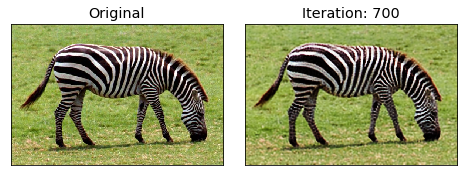

Iteration  750   Loss = 0.000107   PSNR_LR = 39.709667   PSNR_HR=16.47070404 
Iteration  800   Loss = 0.000109   PSNR_LR = 39.628034   PSNR_HR=16.48383232 


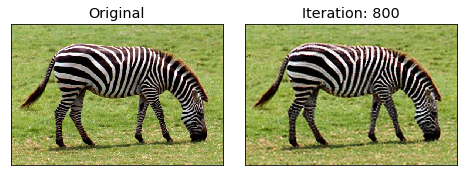

Iteration  850   Loss = 0.000087   PSNR_LR = 40.601276   PSNR_HR=16.45764949 
Iteration  900   Loss = 0.000612   PSNR_LR = 32.134915   PSNR_HR=16.67547878 


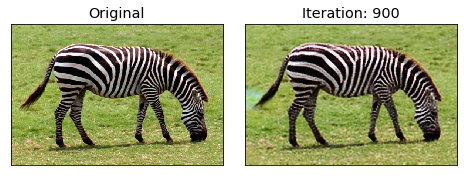

Iteration  950   Loss = 0.000098   PSNR_LR = 40.104493   PSNR_HR=16.46140606 
Iteration  1000   Loss = 0.000077   PSNR_LR = 41.144967   PSNR_HR=16.43791414 


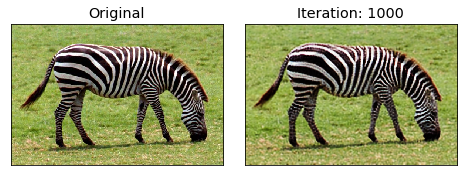

Iteration  1050   Loss = 0.000071   PSNR_LR = 41.494292   PSNR_HR=16.42230606 
Iteration  1100   Loss = 0.000062   PSNR_LR = 42.076510   PSNR_HR=16.41820808 


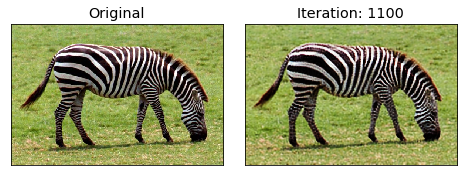

Iteration  1150   Loss = 0.000057   PSNR_LR = 42.474033   PSNR_HR=16.41009696 
Iteration  1200   Loss = 0.000101   PSNR_LR = 39.960571   PSNR_HR=16.40783535 


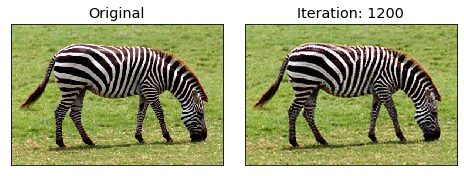

Iteration  1250   Loss = 0.000047   PSNR_LR = 43.309975   PSNR_HR=16.38829595 
Iteration  1300   Loss = 0.000044   PSNR_LR = 43.523623   PSNR_HR=16.38130707 


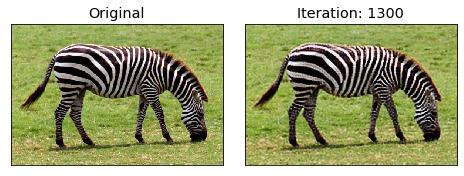

Iteration  1350   Loss = 0.000041   PSNR_LR = 43.857103   PSNR_HR=16.37570303 
Iteration  1400   Loss = 0.000038   PSNR_LR = 44.191975   PSNR_HR=16.36723434 


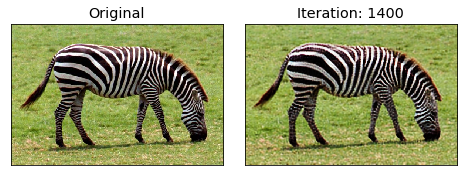

Iteration  1450   Loss = 0.000066   PSNR_LR = 41.814793   PSNR_HR=16.38229898 
Iteration  1500   Loss = 0.000036   PSNR_LR = 44.489170   PSNR_HR=16.34937171 


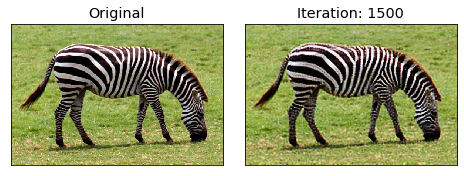

Iteration  1550   Loss = 0.000063   PSNR_LR = 42.018846   PSNR_HR=16.36597070 
Iteration  1600   Loss = 0.000029   PSNR_LR = 45.402380   PSNR_HR=16.33606464 


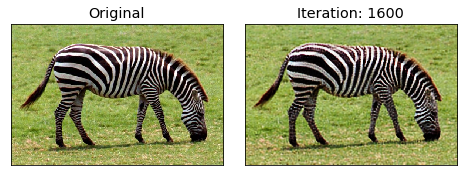

Iteration  1650   Loss = 0.000042   PSNR_LR = 43.747212   PSNR_HR=16.32710808 
Iteration  1700   Loss = 0.000037   PSNR_LR = 44.317487   PSNR_HR=16.32857878 


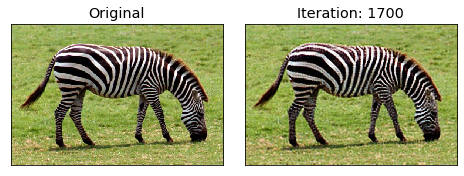

Iteration  1750   Loss = 0.000075   PSNR_LR = 41.261237   PSNR_HR=16.33415353 
Iteration  1800   Loss = 0.000025   PSNR_LR = 45.954370   PSNR_HR=16.31892727 


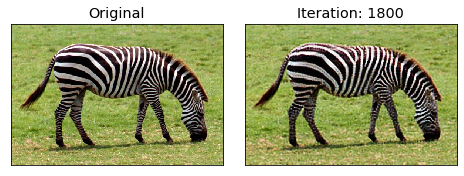

Iteration  1850   Loss = 0.000026   PSNR_LR = 45.910256   PSNR_HR=16.30610808 
Iteration  1900   Loss = 0.000023   PSNR_LR = 46.405033   PSNR_HR=16.31190505 


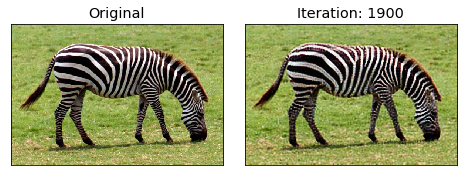

Iteration  1950   Loss = 0.000020   PSNR_LR = 46.892828   PSNR_HR=16.29815555 
Done training final Loss = 2.329200469830539e-05   PSNR_LR = 46.32793129725442   PSNR_HR = 16.294937827182338


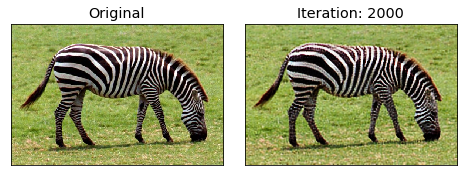

In [7]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)

for i in range(num_iter):
    optimizer.zero_grad()
    
    out = net(net_input)
    out_copy = out.detach().cpu()
    out_down = lanczos_downsample(out, factor, device=device)
    
    loss = mse(out_down, img_lr_tr.to(device))
    loss.backward()
    
    psnr_lr = peak_signal_noise_ratio(img_lr_np, out_down.detach().cpu().numpy()[0]) 
    psnr_hr = peak_signal_noise_ratio(img_hr_np, out_copy.numpy()[0]) 
    
    optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR = %06f' % 
          (i, loss.item(), psnr_lr, psnr_hr), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR=%06f' % 
              (i, loss.item(), psnr_lr, psnr_hr))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_hr_tr, out_copy[0]], 
                                      titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR_LR = {psnr_lr}   PSNR_HR = {psnr_hr}')
fig, axes = tensors_as_images([img_hr_tr, out_copy[0].detach()], 
                                    titles=['Original', f'Iteration: {num_iter}'])

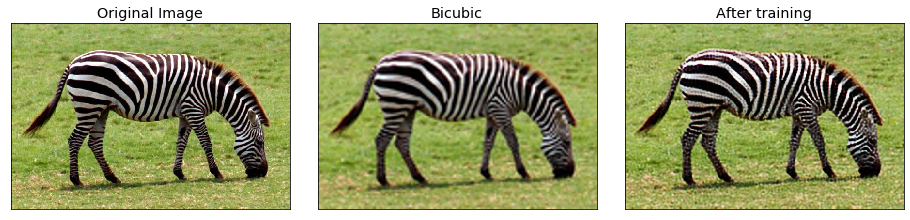

In [8]:
# Showing result of the training using original noise and random noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    
    fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr, output], 
                                        titles=['Original Image', 'Bicubic', 'After training'],
                                        figsize=(16,16))
    
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/sr/{IMAGE}.png')
# will need to use original noise to do denoising

In [9]:
# Try to get better results by changing z_input a bit
with torch.no_grad():
    a = torch.rand(*original_noise.shape)  
    
    best_psnr = 0
    best_p = 0
    results = []
    values = list(np.arange(0.000, 0.015,0.015/20))
    
    for p in reversed(values):
        a[abs(a) > p] = 0
        
        new_noise = original_noise + a.to(device)
        output = net(new_noise).detach()
        psnr_gt = peak_signal_noise_ratio(img_hr_np, output.detach().cpu().numpy()[0]) 
        output = output.squeeze(dim=0)
        results.append(output.clone())
        
        if psnr > best_psnr:
            best_psnr = psnr
            best_p = p
            
    print(f' Best PSNR = %f   Best p = %f' % (best_psnr, best_p))
    nrows = int(len(values)/4)
    fig, axes = tensors_as_images(results, titles=[f'p=%f' % p for p in reversed(values)],
                                        nrows=nrows, figsize=(32,32), cmap='Greys')
        

NameError: name 'psnr' is not defined